# An Epidemilogical Study - INF200 Deliverable

In this notebook, we will implement a numerical method that solve a system of inital value ODEs. The system of ODEs describe the rate of infected, recovered (or removed) and susceptible individuals over time.  We will model and plot the number of individuals belonging to each category mentionned. We will also investigate how varying different parameters (such as vacctionation rate or time of vaccination) affects the model.  



In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

# Constructing Functions to Solve and Visualize ODE

In this section, we will construct a set of functions that together work to solve and plot the results of and ODE-problem. The functions in this section are:

1. The dynamics model which is the ODE to be solved. 
2. Function solving the ODE (numerical solution)
3. Function implementing and plotting the results 

## The Dynamics Model

This is a simple model that models spread of disease in a population. It divvides the population into three groups:
* S: Susceptible individuals, meaning individuals that are yet to be infected
* I: Infected individuals
* R: Removed individuals, meaning individuals that have recovered from infection or died. Can no longer be infected. 

The three measures, when also taking vaccination into account, are related in a system of ODEs the following manner:

$$
\frac{dS}{dt} = -\frac{\beta IS}{N} - \phi S \Theta (t-T_v) \\
\frac{dI}{dt} = \frac{\beta IS}{N} - \gamma I \\
\frac{dR}{dt} = \gamma I + \phi S \Theta (t-T_v)
$$
$\beta$ and $\gamma$ are two numbers that describe the reproduction rate. $T_v$ is the time of vaccination (and has to lie in the span of $t-$values), while $\phi$ is the vaccination rate. $\Theta$ is the heaviside-function, since it would not make sense that $T_v$ could exceed $t$.

Lastly, we have that the sum of each compartment is the total population size (naturally):

$$
S + I + R = N
$$

The first model, called the dynamics model, returns the derivative of these measures (with respect to time). In other words, it returns how quickly these three compartments grow over time. 

In [2]:
def sir_dynamics(t, y, beta, gamma, phi, T_v):
    """
    Function that takes in:
    t     - time [days]
    y     - state vector [S, I, R] at time t
    beta  - infection parameter
    gamma - recovery parameter
    phi   - vaccination parameter
    T_v   - vaccination only for t > T_v
    
    Function which returns an array of values for differential equation
    [dS/dt, dI/dt, dR/dt]
    """
    S, I, R = y 
    N = S + I + R
    dS = -beta*I*S/N - phi*S*( t > T_v)
    dI = beta*I*S/N - gamma*I
    dR = gamma*I + phi*S*(t > T_v)
    return np.array([dS, dI, dR])

## Function Solving ODE

The previous function, `sir_dynamics`, initializes parameters ($I_0$, population size etc.) and defines a set of differential equations (ODE). The function in this section, `sir_model`, solves the differential expressions using scipy's intregrate module. 

Keep in mind that when t = 0, no individuals have died or recovered yet, hence we get that:
$$
N = I_0 + S_0 + R_0 \\
N = I_0 + S_0  \\
\Rightarrow S_0 = N - I_0
$$

The function to be used, solve_ivp, takes input in the following way:

1. The first argument: is the function. The function should be structured in a way so that the first argument is t (time) and second argument is the initial y-values.
2. The second argument: is the span of t-values to solve for. 
3. The third argument: is the inital conditions ($y_0$)
4. The last agrument: args refers to other arguments that have to be specified in the differential equation function

In [3]:

def sir_model(t_max, N, I_0, beta, gamma, phi=0, T_v=0):
    """
    Function which solves a vector of differential equations
    and returns a vector of solutions. Input parameters are:
    t_max  - upper time limit [days]
    N      - population size
    I_0    - number of infected at t = 0
    Output is a vector that contains:
    sol.t  - the t-values that we have solved for 
    sol.y  - Solutions for [S,I,R] at a given t. 
    """
    sol = solve_ivp(sir_dynamics, 
                   [0, t_max], 
                   [N-I_0, I_0, 0], 
                   args = (beta, gamma, phi, T_v), 
                   t_eval = np.arange(0, t_max + 0.5))

    return sol.t, sol.y.T

## Implementing and Plotting Function

Lastly, we create a function `` that makes it easy to plot the results. The function both runs the solver and plots the results for us. The star used inside plt.plot is a method reffered to as *iterable unpacking*. Since the function `sir_model` returns two arrays, we can unpack the results in a way so that we associate a set of t-values to different solutions for y (S,I and R respectively).

In [4]:

def sir_model_and_plot(t_max, N, I_0, beta, gamma, phi=0, T_v=0):
    plt.plot(*sir_model(t_max, N, I_0, beta, gamma, phi, T_v));
    plt.legend(['S', 'I', 'R']);
    plt.xlabel('Time [days]');
    plt.ylabel('Number of people');
    plt.title(rf'Dynamics for $\beta={beta}$, $\phi={phi}$ and $T_v={T_v}$');
    
    

# Exploring the Model
In this section we explore the model by varying different parameters. The following parameters are set to (and not changed during the simulations below):

$$
\gamma = 0.1, N = 1000, I_0 = 1
$$

## No Vaccination 
We set the vaccination level to $\phi$ = 0, and explore different values for $\beta \in [0.01, 1]$. We plot the results for up to 200 days ($t_{max} = 200$)

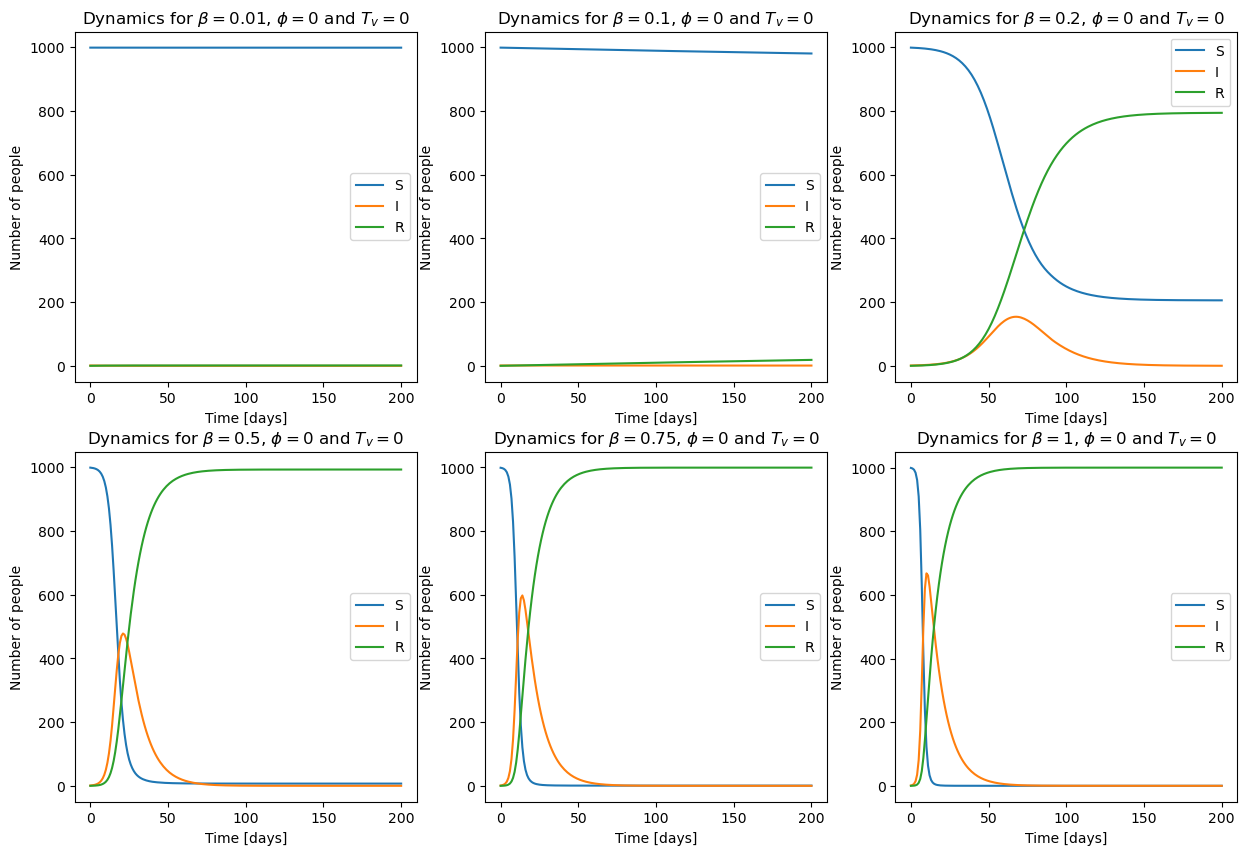

In [5]:
plt.figure(figsize=(15, 10))   # Adjusting figure size to avoid overplotting
for i, beta_val in enumerate([0.01,0.1,0.2, 0.5,0.75,1]):
    plt.subplot(2,3,i+1) #Creating a new subplot and moving about in the grid
    sir_model_and_plot(t_max = 200, N = 1000, I_0 = 1, beta = beta_val, gamma = 0.1)

The $\beta$-parameter is related to the reproduction number($R_0 = \beta/\gamma$). We see that with increasing value for $\beta$ the number of infected individuals increase- The maximum number of infected individuals also occurs earlier for larger values of $\beta$. This makes sense, since we expect that when reproduction number increases the expected number of infected individuals increase.

It follows that as I changes, the number of recovered/removed (R) indivuals changes as well (see the system of ODEs). We therefore also see that R increases with increasing value of $\beta$. 

## With vaccination
First, we chose the $\beta$-value that in the previous section for which the maximum of $I(t)$ is at least 300. We see that this is $\beta = 0.5$. 

We may now first test different vaccination rates ($\phi \in [0.001,0.1]$) and assume that the vaccination time is $T_v = 10$

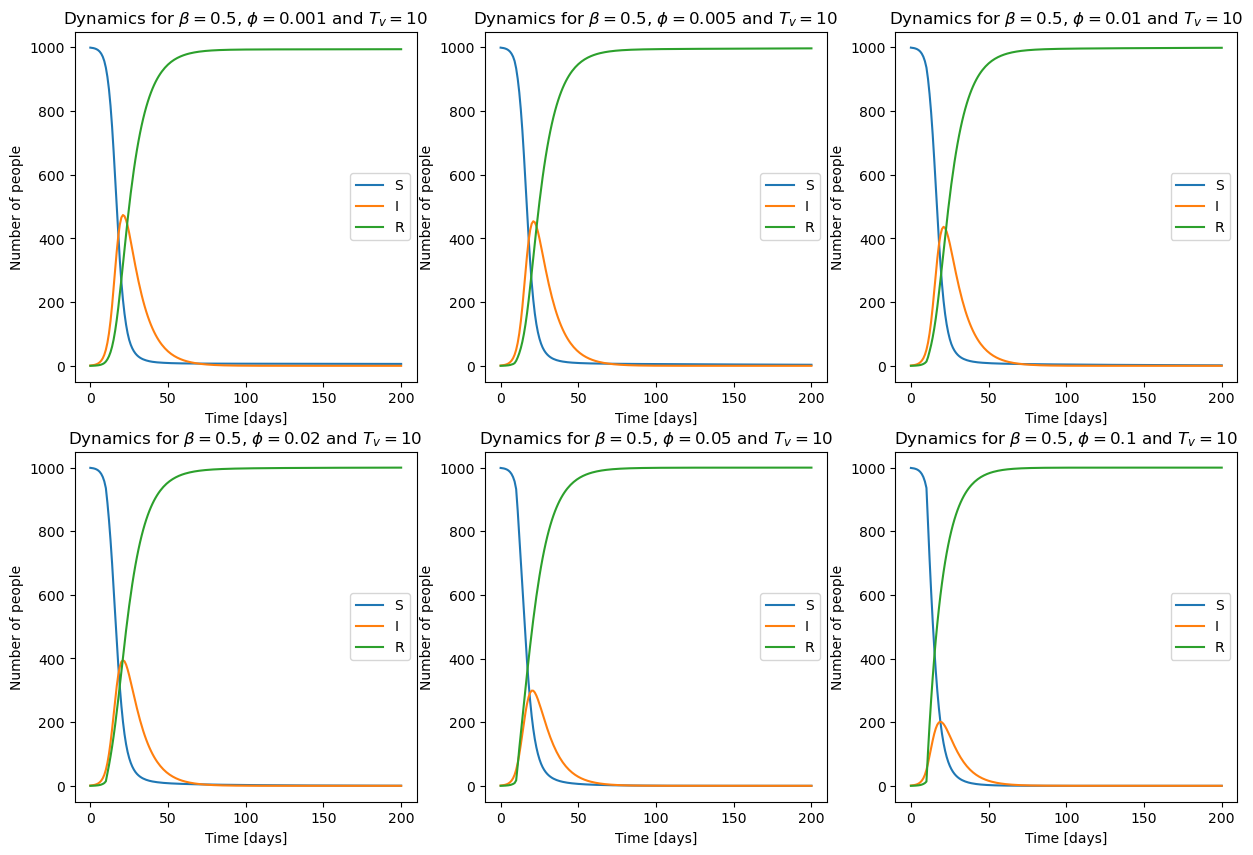

In [6]:
plt.figure(figsize=(15, 10))   # Adjusting figure size to avoid overplotting
for i, phi_val in enumerate([0.001,0.005,0.01, 0.02,0.05,0.1]):
    plt.subplot(2,3,i+1) #Creating a new subplot and moving about in the grid
    sir_model_and_plot(t_max = 200, N = 1000, I_0 = 1, beta = 0.5, gamma = 0.1, phi = phi_val, T_v = 10)

The vaccination rate affects mainly the number of infected individuals (I). We see that as the vaccination rate increases, the maximum number of infected individuals decreases. Furthermor

Next, we keep the vacination rate constant ($\phi = 0.1$), while we vary the value of vaccination time $T_v$

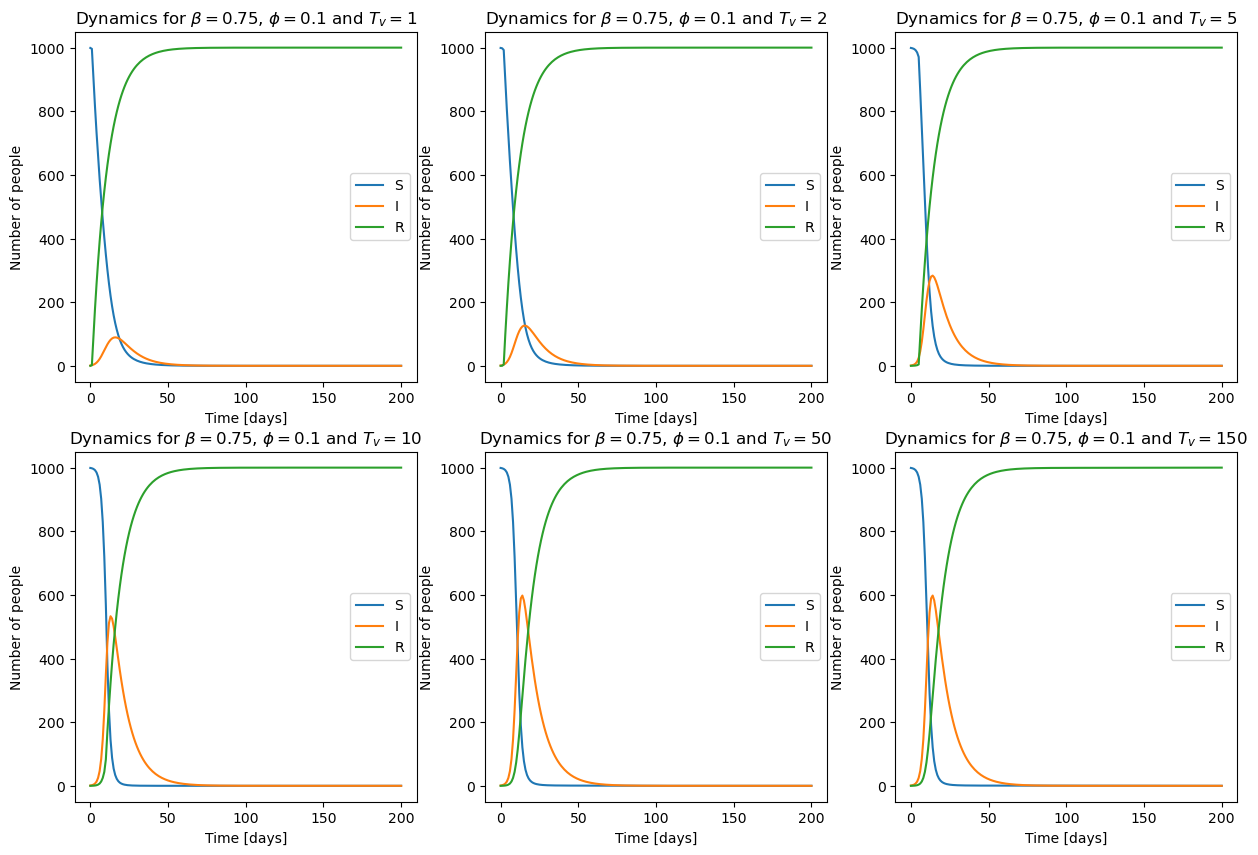

In [7]:
plt.figure(figsize=(15, 10))   # Adjusting figure size to avoid overplotting
for i, T_vval in enumerate([1, 2, 5, 10, 50, 150]):
    plt.subplot(2,3,i+1) #Creating a new subplot and moving about in the grid
    sir_model_and_plot(t_max = 200, N = 1000, I_0 = 1, beta = 0.75, gamma = 0.1, phi = 0.1, T_v = T_vval)

We see that the earlier the time of vaccination is set to ( low $T_v$-values), the smaller the maximum number of infected indiviuals is. As $T_v$ increases, the number of infected individuals early in the simulation increases. 

## Parameter Dependence

We now move on to explore how the two parameters ($\beta$ and $\phi$) affect the maximum number of individuals affected.In other words, we will extract the maximum value $I(t)$ can have over the 200-day period. The first part of the code initializes values for the parameters mentioned, and an empty matrix to be filled with $I_{max}$-values. Next, we will use pyplot's colormesh-plot to visualize how different values of $\beta$ and $\phi$ yield different $I_{max}$ values. The $I_{max}$ values will be simulated using the `sir_model`-function developed earlier. 

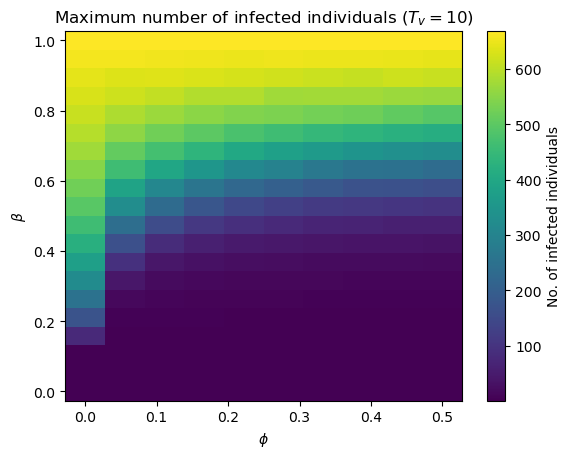

In [8]:
beta_values =np.linspace(0,1,20, endpoint=True)
phi_values = np.linspace(0,0.5,10, endpoint = True)
#Empty matrix to store results
I_max_values = np.zeros((len(beta_values), len(phi_values)))

for bx, b in enumerate(beta_values):
    for px, p in enumerate(phi_values):   
        # Running the model and saving results in res_vec
        res_vec = sir_model(t_max = 200, N = 1000, I_0 = 1, beta = b, gamma = 0.1, phi=p, T_v=10)
        # Extracting column that contains I-values
        I_max = np.max(res_vec[1][:,1]) 
        I_max_values[bx,px] = I_max

# Plotting a color mesh grid
plt.pcolormesh(phi_values, beta_values, I_max_values);
plt.xlabel(r'$\phi$');
plt.ylabel(r'$\beta$');
plt.title(f'Maximum number of infected individuals ($T_v=10$)');
cb = plt.colorbar();
cb.ax.set_ylabel('No. of infected individuals');

Again, keep in mind that $\beta$ is used to define the reproduction number ($R_0 = \frac{\beta}{\phi}$). In simple terms, the reproduction number describes the expected number of people an ill individual will infect. We see that the maximum number of infected individuals increase as $\beta$ increases. 

$\phi$, on the other hand, describes vaccination rates. Unsuprsingly, we see that increased rates of vaccination lead to a reduction in the maximum number of infected individuals. The effect of high vaccination rate are limited when estimated reproduction number is high (assuming high $\beta$ indicates high reproduction no.). 

Overall, we can conclude that the parameters $\beta$ and $\phi$ work in opposite directions on the value of $I_{max}$
